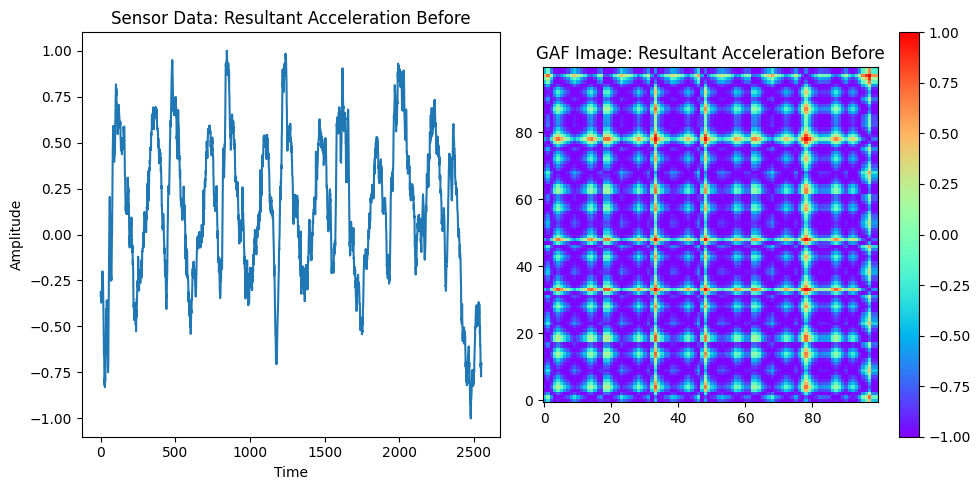

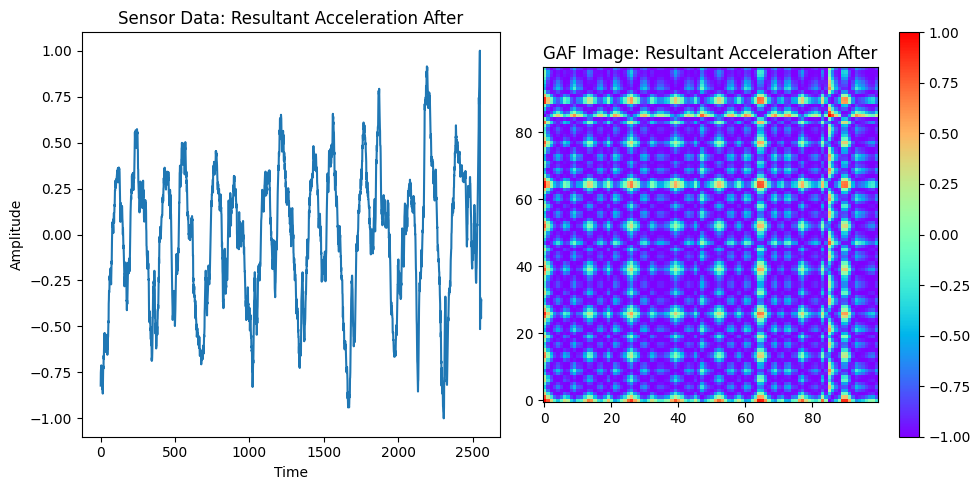

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pyts.image import GramianAngularField
from scipy.signal import butter, filtfilt

def load_sensor_data(file_path, sheet_name, columns_to_load):
    """Load sensor data from an Excel file."""
    return pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_load)

def high_pass_filter(data, cutoff=0.3, fs=256, order=5):
    """
    Apply a high-pass Butterworth filter to remove gravity component.
    
    Parameters:
    - data: The accelerometer data array.
    - cutoff: The cutoff frequency in Hz.
    - fs: The sampling rate of the data in Hz.
    - order: The order of the filter.
    
    Returns:
    - Filtered data with gravity component removed.
    """
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def calculate_resultant_acceleration(data_df):
    """Calculate the resultant acceleration from accelerometer data."""
    #ax = data_df['Sensor_1_Acc_X'].values
    #ay = data_df['Sensor_1_Acc_Y'].values
    #az = data_df['Sensor_1_Acc_Z'].values
    ax, ay, az = data_df[:, 0], data_df[:, 1], data_df[:, 2]
    a_res = np.sqrt(ax**2 + ay**2 + az**2)
    return a_res

def generate_gaf_image(sensor_data, image_size=100):
    """Generate a GAF image from sensor data.
    sensor_data: 1D NumPy array of sensor data
    image_size: Desired size of the square GAF image
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # Assuming sensor_data is already a 1D NumPy array, reshape for scaling
    scaled_data = scaler.fit_transform(sensor_data.reshape(-1, 1))
    
    # Reshape scaled_data back to a flat array for GAF transformation
    scaled_data_flat = scaled_data.flatten()
    
    gaf_transformer = GramianAngularField(image_size=image_size, method='summation')
    # Reshape scaled_data_flat to fit_transform requirements (samples, features)
    gaf_image = gaf_transformer.fit_transform(scaled_data_flat.reshape(1, -1))
    
    return gaf_image[0], scaled_data

def plot_sensor_data_and_gaf(sensor_data, gaf_image, column_name):
    """Plot sensor data and its GAF image side by side."""
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot sensor data
    axs[0].plot(sensor_data)
    axs[0].set_title(f'Sensor Data: {column_name}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Amplitude')
    
    # Plot GAF image
    im = axs[1].imshow(gaf_image, cmap='rainbow', origin='lower')
    axs[1].set_title(f'GAF Image: {column_name}')
    fig.colorbar(im, ax=axs[1], orientation='vertical')
    
    plt.tight_layout()
    plt.show()

# File paths
file_path_before = 'D:\\VR_MIRROR\\Raw Data_VR MIRROR\\With Correct trails_ excel\\Data before excel\\PD-group-Before VR\\ID1-before-Exo1.xlsx'
file_path_after = 'D:\\VR_MIRROR\\Raw Data_VR MIRROR\\With Correct trails_ excel\\Data after excel\\PD-group-After VR\\ID1-after-Exo1.xlsx'

# Sheet and columns to load
sheet_name = 'Matavimas # 1'
columns_to_load = ['Sensor_1_Acc_X', 'Sensor_1_Acc_Y', 'Sensor_1_Acc_Z', 'Sensor_1_Gyr_X', 'Sensor_1_Gyr_Y', 'Sensor_1_Gyr_Z']

# Load the data
data_df_before = load_sensor_data(file_path_before, sheet_name, columns_to_load)
data_df_after = load_sensor_data(file_path_after, sheet_name, columns_to_load)

# filter the data (removing Gravity via high-pass filtering)
acc_filt_before = np.apply_along_axis(high_pass_filter, 0, data_df_before)
acc_filt_after = np.apply_along_axis(high_pass_filter, 0, data_df_after)

# Calculate resultant acceleration
a_res_before = calculate_resultant_acceleration(acc_filt_before)
a_res_after = calculate_resultant_acceleration(acc_filt_after)

# Generate and plot GAF images for a specific sensor before and after
for column_name in ['Sensor_1_Acc_X']:  # Extend or modify this list as needed
    gaf_image_before, sensor_data_before = generate_gaf_image(a_res_before)  # Assuming first 100 data points
    plot_sensor_data_and_gaf(sensor_data_before.flatten(), gaf_image_before, 'Resultant Acceleration Before')

    gaf_image_after, sensor_data_after = generate_gaf_image(a_res_after)  # Assuming first 100 data points
    plot_sensor_data_and_gaf(sensor_data_after.flatten(), gaf_image_after, 'Resultant Acceleration After')